In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from scipy.spatial import ConvexHull
from itertools import combinations
import pandas as pd

In [2]:
def to_stringa(punti, forma):
    return ";".join(f"{x:.3f}:{y:.3f}" for x, y in punti)+','+forma

def genera_segmento(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    # Calcola le coordinate dei due estremi del segmento
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    # Interpolazione lineare tra i due estremi per ottenere i punti
    t = np.linspace(0, 1, n_punti)
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    # Aggiunta di rumore gaussiano alle coordinate
    x += np.random.normal(0, rumore_std, size=n_punti)
    y += np.random.normal(0, rumore_std, size=n_punti)
    # Restituisce un array Nx2 con i punti generati
    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)

def genera_croce(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    # Primo segmento (angolo theta)
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    t = np.linspace(0, 1, n_punti//2)
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    x += np.random.normal(0, rumore_std, size=n_punti//2)
    y += np.random.normal(0, rumore_std, size=n_punti//2)

    # Secondo segmento (angolo theta + 90°)
    x1 = x0 - l * np.sin(theta)
    y1 = y0 + l * np.cos(theta)
    x2 = x0 + l * np.sin(theta)
    y2 = y0 - l * np.cos(theta)
    t = np.linspace(0, 1, n_punti//2)
    xx = x1 + t * (x2 - x1)
    yy = y1 + t * (y2 - y1)
    xx += np.random.normal(0, rumore_std, size=n_punti//2)
    yy += np.random.normal(0, rumore_std, size=n_punti//2)

    # Unisce i punti dei due segmenti
    x = np.concatenate([x, xx])
    y = np.concatenate([y, yy])

    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)



def genera_ellisse(a=1.0, b=0.5, centro=(0, 0), angolo=0.0, n_punti=100, rumore_std=0.0):
    t = np.linspace(0, 2 * np.pi, n_punti)
    x = a * np.cos(t)
    y = b * np.sin(t)

    # Rotazione
    x_rot = x * np.cos(angolo) - y * np.sin(angolo)
    y_rot = x * np.sin(angolo) + y * np.cos(angolo)

    # Traslazione
    x_finale = x_rot + centro[0]
    y_finale = y_rot + centro[1]

    # Rumore
    x_finale += np.random.normal(0, rumore_std, size=n_punti)
    y_finale += np.random.normal(0, rumore_std, size=n_punti)

    return np.stack([x_finale, y_finale], axis=1)


def genera_rettangolo(larghezza=1.0, altezza=0.5, centro=(0, 0), angolo=0.0,
            rumore_std=0.0, n_punti=100):
    if n_punti < 4:
        raise ValueError("n_punti deve essere almeno 4")

    # Vertici base
    w, h = larghezza / 2, altezza / 2
    vertici = np.array([
        [-w, -h],
        [ w, -h],
        [ w,  h],
        [-w,  h]
    ])

    # Lati e lunghezze
    lati = [(vertici[(i+1) % 4] - vertici[i]) for i in range(4)]
    lunghezze = np.array([np.linalg.norm(l) for l in lati])
    proporzioni = lunghezze / lunghezze.sum()

    # Distribuzione dei punti
    n_per_lato = np.floor(proporzioni * n_punti).astype(int)
    restante = n_punti - n_per_lato.sum()
    for i in range(restante):
        n_per_lato[i % 4] += 1

    # Generazione dei punti
    punti = []
    for i, n in enumerate(n_per_lato):
        start = vertici[i]
        end = vertici[(i + 1) % 4]
        t_values = np.linspace(0, 1, n, endpoint=False)
        lato = np.outer(1 - t_values, start) + np.outer(t_values, end)
        punti.append(lato)
    punti = np.vstack(punti)

    # Rotazione, traslazione e rumore
    R = np.array([
        [np.cos(angolo), -np.sin(angolo)],
        [np.sin(angolo),  np.cos(angolo)]
    ])
    punti = punti @ R.T
    punti += np.array(centro)
    punti += np.random.normal(0, rumore_std, punti.shape)

    return punti

### Generazione Dataset


In [ ]:
def genera_campioni(n_shapes = 100, n_punti = 50, rumore_std_bound=0):

    X, y = [], []  # Liste per memorizzare i campioni e le etichette

    # Genera ellissi
    for _ in range(n_shapes):
        a = np.random.uniform(0.5, 3.0)                  # semiasse maggiore
        b = np.random.uniform(0.3, a)                    # semiasse minore
        centro = (np.random.uniform(-5, 5), np.random.uniform(-5, 5))  # centro casuale
        angolo = np.random.uniform(0, 2 * np.pi)         # rotazione casuale
        rumore = np.random.uniform(0.0, rumore_std_bound)  # rumore casuale
        punti = genera_ellisse(a, b, centro, angolo, n_punti=n_punti, rumore_std=rumore)  # genera punti
        X.append(punti)
        y.append(0)  # 0 = ellisse

    # Genera rettangoli
    for _ in range(n_shapes):
        punti = genera_rettangolo(
            larghezza=np.random.uniform(0.5, 3.0),       # larghezza casuale
            altezza=np.random.uniform(0.5, 2.0),         # altezza casuale
            centro=(np.random.uniform(-5, 5), np.random.uniform(-5, 5)),  # centro casuale
            angolo=np.random.uniform(0, 2*np.pi),        # rotazione casuale
            rumore_std = np.random.uniform(0.0, rumore_std_bound),        # rumore casuale
            n_punti = n_punti
        )
        X.append(punti)
        y.append(1) # 1 = rettangolo

    # Genera segmenti
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_segmento(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(2)
        
    # Genera croci (due segmenti ortogonali)
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_croce(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(3)  # 3 = croce
        

    return np.array(X), np.array(y)  # restituisce array di campioni e etichette


In [4]:
def ottieni_features(X):
    return np.array([list(x.flatten()) for x in X])

In [5]:
labels = ['ellisse', 'rettangolo', 'segmento', 'croce']

In [61]:
X, y = genera_campioni(n_shapes=4000, n_punti=100, rumore_std_bound=0.00001)
X_flat = ottieni_features(X)

In [ ]:
def extract_geometric_features(pts):
    """
    pts: array (n_punti, 2)
    Restituisce un dict con le feature geometriche.
    """
    # 1. Centroid
    cx, cy = pts.mean(axis=0)
    # distanze dal centroide
    dists = np.linalg.norm(pts - (cx, cy), axis=1)
    dist_mean = dists.mean()
    dist_std  = dists.std()

    # 2. Perimetro
    diffs = np.diff(pts, axis=0, append=pts[:1])
    perimeter = np.linalg.norm(diffs, axis=1).sum()

    # 3. Area (shoelace)
    x, y = pts[:,0], pts[:,1]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))

    # 4. Bounding-box aspect ratio
    minx, maxx = x.min(), x.max()
    miny, maxy = y.min(), y.max()
    width, height = maxx - minx, maxy - miny
    aspect_ratio = width / height if height>0 else 0

    # 5. Extreme distances
    # (costo O(n^2), per n~100 va bene)
    dists_all = [np.linalg.norm(p-q) for p, q in combinations(pts, 2)]
    d_max = max(dists_all)
    d_min = min(dists_all)

    # 6. Convex hull
    hull = ConvexHull(pts)
    hull_area = hull.volume    # in 2D volume è l’area
    hull_perim = hull.area     # in 2D area è il perimetro dell’inviluppo
    hull_ratio = area / hull_area if hull_area>0 else 0

    # 7. Compactness
    compactness = 4*np.pi*area/(perimeter**2) if perimeter>0 else 0

    # 8. Eccentricity (PCA sui punti)
    # calcolo cov e autovalori
    cov = np.cov(pts.T)
    evals, _ = np.linalg.eig(cov)
    # rapport tra max e min asse
    ecc = np.sqrt(evals.max()/evals.min()) if evals.min()>0 else 0
    

In [ ]:
X_flat = np.array([shape.flatten() for shape in X])

# 2) Genera i nomi delle colonne: x0,y0,x1,y1,…,x{n_punti-1},y{n_punti-1}
n_punti = X.shape[1]
cols_xy = []
for i in range(n_punti):
    cols_xy += [f'x{i}', f'y{i}']

# 3) Costruisci df_flat e assegna la label
df_flat = pd.DataFrame(X_flat, columns=cols_xy)  # ora len(y)==len(df_flat), non hai mismatch!

# Controlla
print(df_flat.shape)   # (n_shapes, 200+1)
print(df_flat.head())

(16000, 201)
         x0        y0        x1        y1        x2        y2        x3  \
0  0.696772 -0.903168  0.674861 -0.882416  0.649758 -0.864758  0.621556   
1  4.295268  1.383736  4.235295  1.520844  4.165366  1.653432  4.085763   
2  4.545896  2.738013  4.558644  2.788257  4.567518  2.839467  4.572463   
3 -4.078676 -4.110146 -4.002682 -4.084295 -3.929404 -4.049872 -3.859150   
4 -2.592813  3.708829 -2.584786  3.754956 -2.580741  3.801744 -2.580707   

         y3        x4        y4  ...       y95       x96       y96       x97  \
0 -0.850236  0.590372 -0.838927  ... -1.015032  0.742533 -0.982942  0.730670   
1  1.780892  3.996763  1.902715  ...  0.800697  4.413204  0.950454  4.384400   
2  2.891377  4.573484  2.943813  ...  2.550246  4.484883  2.594820  4.508931   
3 -4.007023 -3.792193 -3.955929  ... -4.126380 -4.319895 -4.135465 -4.237607   
4  3.849043 -2.584668  3.896654  ...  3.534822 -2.640447  3.576400 -2.620706   

        y97       x98       y98       x99       y99  la

In [63]:
features_list = []
for shape in X:
    feats = extract_geometric_features(shape)  # dict delle nuove feature
    features_list.append(feats)

In [ ]:
df_geo = pd.DataFrame(features_list)
df_geo['label'] = y 

In [ ]:
df_all = pd.concat([df_flat, df_geo], axis=1)
print(df_all.shape)

(16000, 213)


In [68]:
df_all.to_csv('dataset_geometric_features.csv', index=False)

In [8]:
# 1) Split iniziale: train+val vs test (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_flat, y, test_size=0.2, random_state=42, stratify=y
)

# 2) Split secondario: train vs validation (da quel 80% rimasto, 80% train e 20% validation → 64% train, 16% val)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)


In [9]:
print("Shape di X:", X_train.shape)
print("Shape di y:", y.shape)

Shape di X: (10240, 200)
Shape di y: (16000,)


In [10]:
def get_eigen(A):
    # calcola la media per ogni colonna (feature)
    means = np.mean(A, axis=0)
    # sottrae la media (lungo le colonne): ogni feature ora ha media zero
    M = (A - means)
    # calcola la matrice di covarianza delle righe di A
    c = np.cov(M, rowvar=0)
    # calcola autovalori e autovettori della matrice di covarianza
    [evals, evects] = np.linalg.eig(c)
    # ottiene gli indici degli autovalori ordinati in modo decrescente
    idx = np.argsort(evals)[::-1]
    # ordina gli autovettori (colonne di evects) secondo gli autovalori ordinati
    evects = evects[:, idx]
    # ordina gli autovalori in modo decrescente
    evals = evals[idx]
    return evals, evects, M

def pca(M, vec, numpc=0):
    # Estrae i primi 'numpc' autovettori come base dello spazio ridotto
    basis = vec[:, range(numpc)]
    # Proietta i dati centrati nello spazio delle componenti principali
    projections = np.dot(M, basis)
    # Restituisce la base e le proiezioni
    return basis, projections

In [11]:
numpc = 20

autovalori_test, autovettori_test, M_test = get_eigen(X_test)
base_test, proiezioni_test = pca(M_test, autovettori_test, numpc=numpc)

transformed_test_set = proiezioni_test.dot(base_test.T)

autovalori_train, autovettori_train, M_train = get_eigen(X_train)
base_train, proiezioni_train = pca(M_train, autovettori_train, numpc=numpc)

transformed_train_set = proiezioni_train.dot(base_train.T)

autovalori_val, autovettori_val, M_val = get_eigen(X_val)
base_val, proiezioni_val = pca(M_val, autovettori_train, numpc=numpc)

transformed_train_set = proiezioni_train.dot(base_val.T)

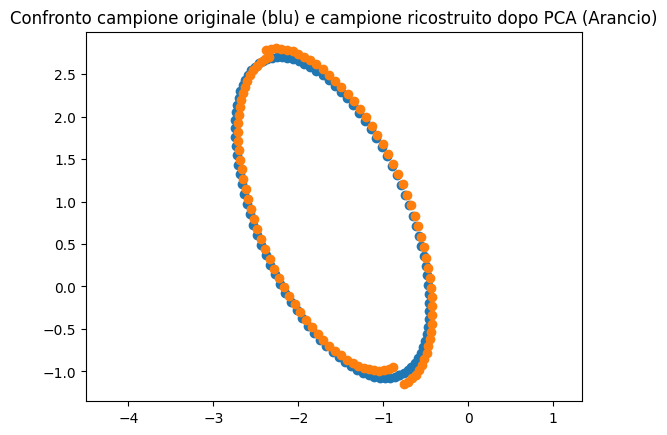

In [20]:

i = np.random.randint(low=1, high=4000)

projected = proiezioni_train.dot(base_train.T)
projected_example_train = projected[i]
transformed_example_train = projected_example_train.reshape(-1,2)

orig = X_train[i].reshape(-1,2)
x  = [orig[i][0] for i in range(orig.shape[0])]
y  = [orig[i][1] for i in range(orig.shape[0])]
ax1 = plt.subplot()
ax1.set_title("Campione originale")
ax1.axis('equal')
ax1.scatter(x,y)

x_recon  = [transformed_example_train[i][0] for i in range(transformed_example_train.shape[0])]
y_recon  = [transformed_example_train[i][1] for i in range(transformed_example_train.shape[0])]
ax2 = plt.subplot()
ax2.set_title("Confronto campione originale (blu) e campione ricostruito dopo PCA (Arancio)")
ax2.axis('equal')
ax2.scatter(x_recon,y_recon)

---

## Feature selection


* Sia gli alberi decisionali singoli (Decision Tree) sia gli ensemble basati su di essi (Random Forest) forniscono automaticamente una misura di importanza di ciascuna feature
* Utilizziamo Random Forest

In [21]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [35]:
importances_rf = rf.feature_importances_

In [56]:
threshold = np.percentile(importances_rf, 10)  # top 25%
mask = importances_rf >= threshold
print("PC mantenute:", np.where(mask)[0])
X_train_sel = X_train[:, mask]
X_test_sel  = X_test[:,  mask]

PC mantenute: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  42  45  47  49  50  51  54  55  56  58  59  60  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 146 147 148 149 150 151 152 153 154
 158 163 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199]


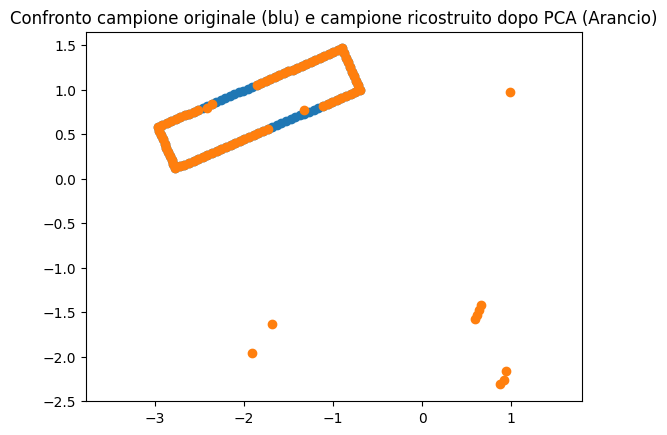

In [57]:
i = np.random.randint(low=1, high=4000)

projected_example_train = X_train_sel[i]
transformed_example_train = projected_example_train.reshape(-1,2)

orig = X_train[i].reshape(-1,2)
x  = [orig[i][0] for i in range(orig.shape[0])]
y  = [orig[i][1] for i in range(orig.shape[0])]
ax1 = plt.subplot()
ax1.set_title("Campione originale")
ax1.axis('equal')
ax1.scatter(x,y)

x_recon  = [transformed_example_train[i][0] for i in range(transformed_example_train.shape[0])]
y_recon  = [transformed_example_train[i][1] for i in range(transformed_example_train.shape[0])]
ax2 = plt.subplot()
ax2.set_title("Confronto campione originale (blu) e campione ricostruito dopo PCA (Arancio)")
ax2.axis('equal')
ax2.scatter(x_recon,y_recon)

In [ ]:
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest

classificatore = mutual_info_classif(X_train, y_train)
dataframe_mutual = pd.DataFrame(classificatore, index=X_train[0, :] ,columns=['mi']).sort_values(by='mi', ascending=False)
dataframe_mutual

da ricostruire